# Overview
* [Loading and processing the datasets](#data-loading)
* [Review lengths](#review-lengths)
* [Class distribution](#label-distribution)
* [Sentiment over time](#sentiment-time)
* [Analyzing n-grams](#ngrams)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from typing import List, Tuple
import matplotlib.pyplot as plt
from datetime import date
from typing import Dict
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

from dataloader import NoReCDataLoader
from preprocessor import NoReCDataPreprocessor

plt.style.use('ggplot')

# Loading data <a class="anchor" id="data-loading"></a>

In [2]:
def load_and_process_data(binary: bool) -> pd.DataFrame:
    dataloader = NoReCDataLoader("./norec/data", False)
    train_ds, val_ds, test_ds = dataloader.load_binary_dataset() if binary else dataloader.load_multiclass_dataset()
    dataset = pd.concat([train_ds, val_ds, test_ds])
    del train_ds, val_ds, test_ds

    dataset["date"] = dataset.apply(lambda x: date(x["year"], x["month"], x["day"]), axis=1)
    dataset = dataset[
        [
            'authors',
            'category',
            'excerpt',
            'language',
            'rating',
            'source',
            'source-category',
            'source-tags',
            'split',
            'tags',
            'title',
            'text',
            'label',
            'date'
        ]
    ]
    return dataset

In [3]:
binary_ds = load_and_process_data(True)
multiclass_ds = load_and_process_data(False)

Loading binary data from source


Loading dev data: 100%|██████████| 4348/4348 [00:00<00:00, 48912.25it/s]


Loading multiclass data from source


Loading dev data: 100%|██████████| 4348/4348 [00:00<00:00, 47528.27it/s]


In [4]:
BINARY_LABEL_TO_ID_MAPPING = {
    "positive": 1,
    "negative": 0
}
BINARY_ID_TO_LABEL_MAPPING = {
    1: "positive",
    0: "negative"
}
MULTICLASS_LABEL_TO_ID_MAPPING = {
    "positive": 2,
    "neutral": 1,
    "negative": 0
}
MULTICLASS_ID_TO_LABEL_MAPPING = {
    2: "positive",
    1: "neutral",
    0: "negative"
}

POSITIVE_COLOR = "#20C997"
NEUTRAL_COLOR = "#3C3C3C"
NEGATIVE_COLOR = "#E83E8C"

BINARY_PALETTE = {0: NEGATIVE_COLOR, 1: POSITIVE_COLOR}
MULTICLASS_PALETTE = {0: NEGATIVE_COLOR, 1: NEUTRAL_COLOR, 2: POSITIVE_COLOR}

# Review lengths <a class="anchor" id="review-lengths"></a>

In [5]:
def get_token_counts(dataset: pd.DataFrame) -> Dict:
    token_counts = {}
    for _, row in dataset.iterrows():
        token_count = len(row["text"].split(" "))
        if row["label"] not in token_counts:
            token_counts[row["label"]] = [token_count]
        else:
            token_counts[row["label"]].append(token_count)
    return token_counts


binary_ds_token_counts = get_token_counts(binary_ds)
multiclass_ds_token_counts = get_token_counts(multiclass_ds)

In [6]:
avg_length = int((sum(binary_ds_token_counts[0]) + sum(binary_ds_token_counts[1])) / (len(binary_ds_token_counts[1]) + len(binary_ds_token_counts[0])))
max_length = max(max(binary_ds_token_counts[0]), max(binary_ds_token_counts[1]))
min_length = min(min(binary_ds_token_counts[0]), min(binary_ds_token_counts[1]))

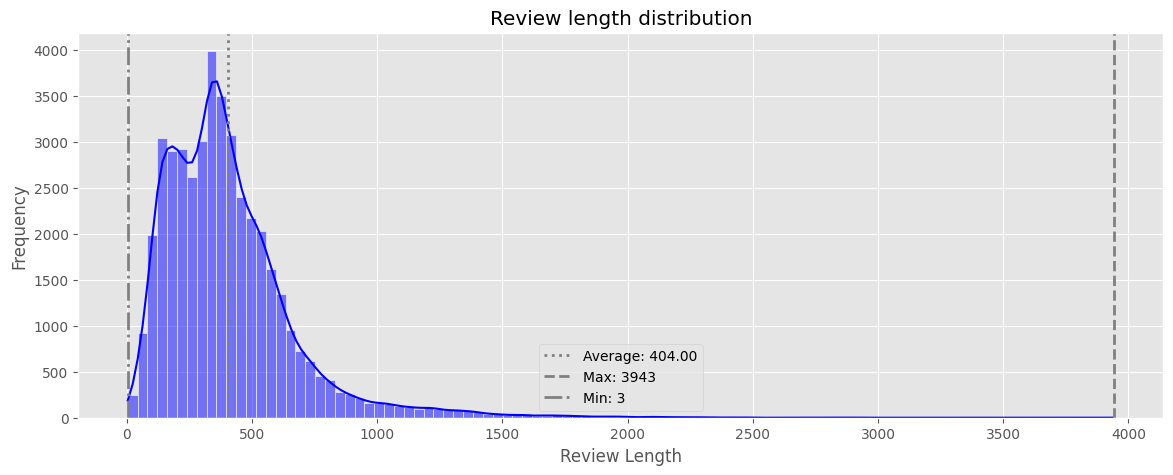

In [7]:
plt.figure(figsize=(14, 5))
sns.histplot(binary_ds_token_counts[0] + binary_ds_token_counts[1], kde=True, color="blue", bins=100)
plt.axvline(avg_length, color='grey', linestyle='dotted', linewidth=2, label=f'Average: {avg_length:.2f}')
plt.axvline(max_length, color='grey', linestyle='dashed', linewidth=2, label=f'Max: {max_length}')
plt.axvline(min_length, color='grey', linestyle='dashdot', linewidth=2, label=f'Min: {min_length}')
plt.title("Review length distribution")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

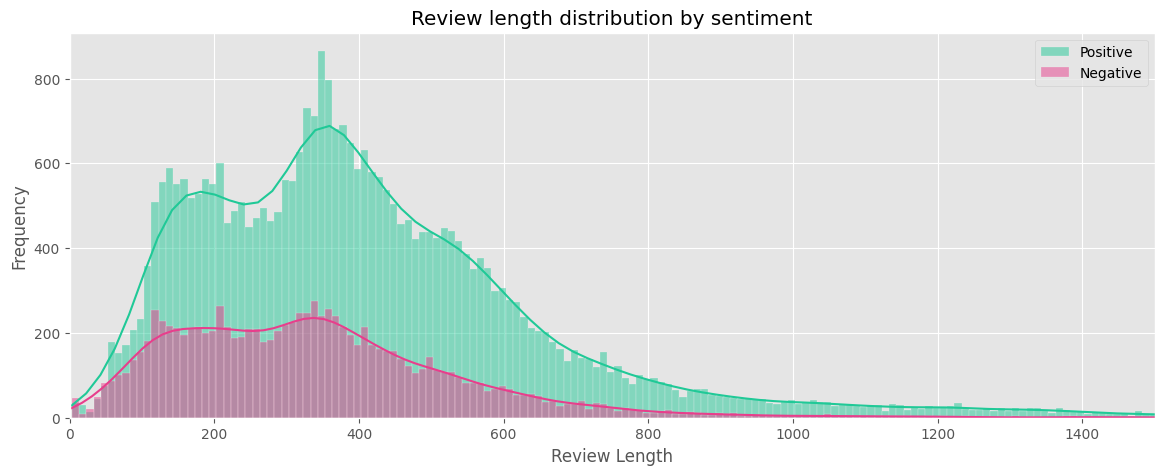

In [8]:
bin_width = 10
bins = range(
    min(min(binary_ds_token_counts[0]), min(binary_ds_token_counts[1])), 
    max(max(binary_ds_token_counts[0]), max(binary_ds_token_counts[1])) + bin_width, 
    bin_width
)

plt.figure(figsize=(14, 5))
sns.histplot(binary_ds_token_counts[1], kde=True, color=POSITIVE_COLOR, bins=bins, label="Positive")
sns.histplot(binary_ds_token_counts[0], kde=True, color=NEGATIVE_COLOR, bins=bins, label="Negative")
plt.xlim([0, 1500])
plt.title("Review length distribution by sentiment")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

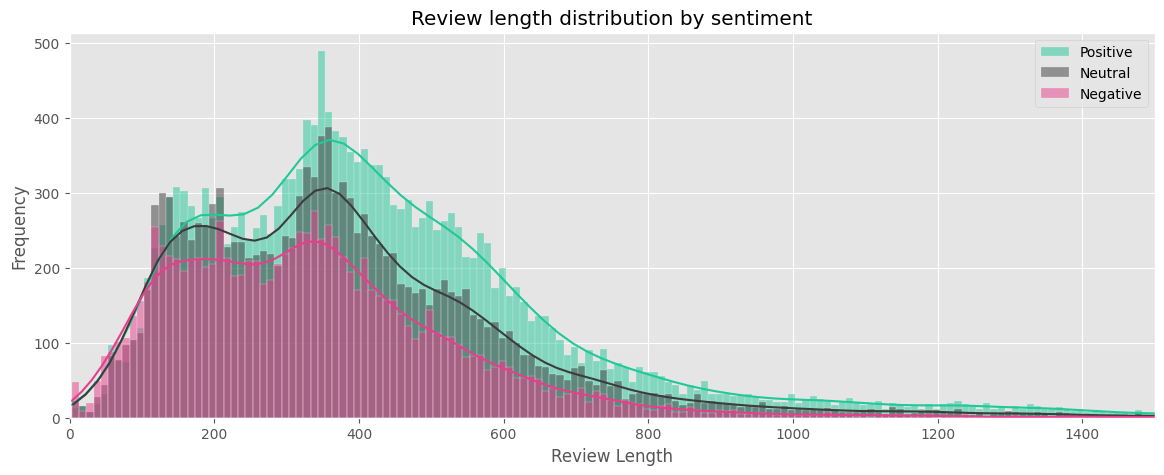

In [9]:
bin_width = 10
bins = range(
    min(min(multiclass_ds_token_counts[0]), min(multiclass_ds_token_counts[1]), min(multiclass_ds_token_counts[2])), 
    max(max(multiclass_ds_token_counts[0]), max(multiclass_ds_token_counts[1]), max(multiclass_ds_token_counts[2])) + bin_width,
    bin_width
)

plt.figure(figsize=(14, 5))
sns.histplot(multiclass_ds_token_counts[2], kde=True, color=POSITIVE_COLOR, bins=bins, label="Positive")
sns.histplot(multiclass_ds_token_counts[1], kde=True, color=NEUTRAL_COLOR, bins=bins, label="Neutral")
sns.histplot(multiclass_ds_token_counts[0], kde=True, color=NEGATIVE_COLOR, bins=bins, label="Negative")
plt.xlim([0, 1500])
plt.title("Review length distribution by sentiment")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Label distribution <a class="anchor" id="label-distribution"></a>

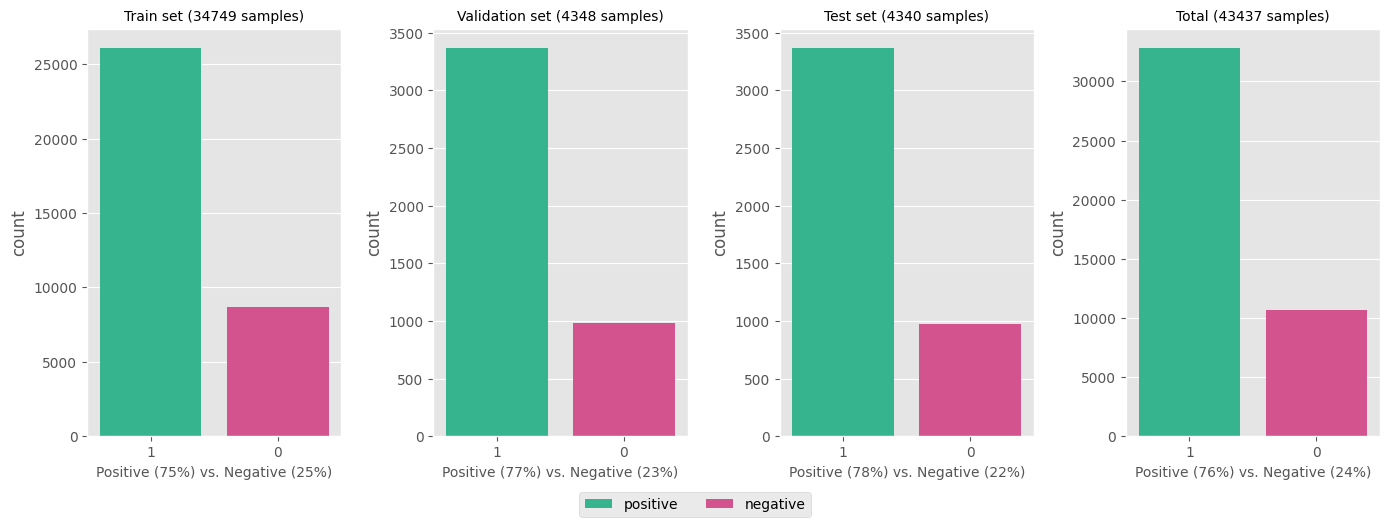

In [10]:
binary_train_ds = binary_ds[binary_ds.split == "train"]
binary_val_ds = binary_ds[binary_ds.split == "dev"]
binary_test_ds = binary_ds[binary_ds.split == "test"]

binary_train_total = binary_train_ds.shape[0]
binary_val_total = binary_val_ds.shape[0]
binary_test_total = binary_test_ds.shape[0]

train_positive_percent = round(binary_train_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)
dev_positive_percent = round(binary_val_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)
test_positive_percent = round(binary_test_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)
total_positive_percent = round(binary_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["positive"]] * 100)

train_negative_percent = round(binary_train_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)
dev_negative_percent = round(binary_val_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)
test_negative_percent = round(binary_test_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)
total_negative_percent = round(binary_ds.label.value_counts(normalize=True)[BINARY_LABEL_TO_ID_MAPPING["negative"]] * 100)


fig, ax = plt.subplots(1, 4, figsize=(14, 5))

sns.countplot(x="label", data=binary_train_ds, ax=ax[0], hue="label", palette=BINARY_PALETTE, order=[1, 0])
ax[0].set_title(f"Train set ({binary_train_total} samples)", fontsize=10)
ax[0].set_xlabel(f"Positive ({train_positive_percent}%) vs. Negative ({train_negative_percent}%)", fontsize=10)
ax[0].get_legend().remove()

sns.countplot(x="label", data=binary_val_ds, ax=ax[1], hue="label", palette=BINARY_PALETTE, order=[1, 0])
ax[1].set_title(f"Validation set ({binary_val_total} samples)", fontsize=10)
ax[1].set_xlabel(f"Positive ({dev_positive_percent}%) vs. Negative ({dev_negative_percent}%)", fontsize=10)
ax[1].get_legend().remove()

sns.countplot(x="label", data=binary_test_ds, ax=ax[2], hue="label", palette=BINARY_PALETTE, order=[1, 0])
ax[2].set_title(f"Test set ({binary_test_total} samples)", fontsize=10)
ax[2].set_xlabel(f"Positive ({test_positive_percent}%) vs. Negative ({test_negative_percent}%)", fontsize=10)
ax[2].get_legend().remove()

sns.countplot(x="label", data=binary_ds, ax=ax[3], hue="label", palette=BINARY_PALETTE, order=[1, 0])
ax[3].set_title(f"Total ({binary_train_total + binary_val_total + binary_test_total} samples)", fontsize=10)
ax[3].set_xlabel(f"Positive ({total_positive_percent}%) vs. Negative ({total_negative_percent}%)", fontsize=10)
ax[3].get_legend().remove()

handles, labels = ax[0].get_legend_handles_labels()
labels = [BINARY_ID_TO_LABEL_MAPPING[int(label)] for label in labels]
fig.legend(handles[::-1], labels[::-1], loc='center', bbox_to_anchor=(0.5, -0.02), fancybox=True, ncol=2)

plt.tight_layout()
plt.show()

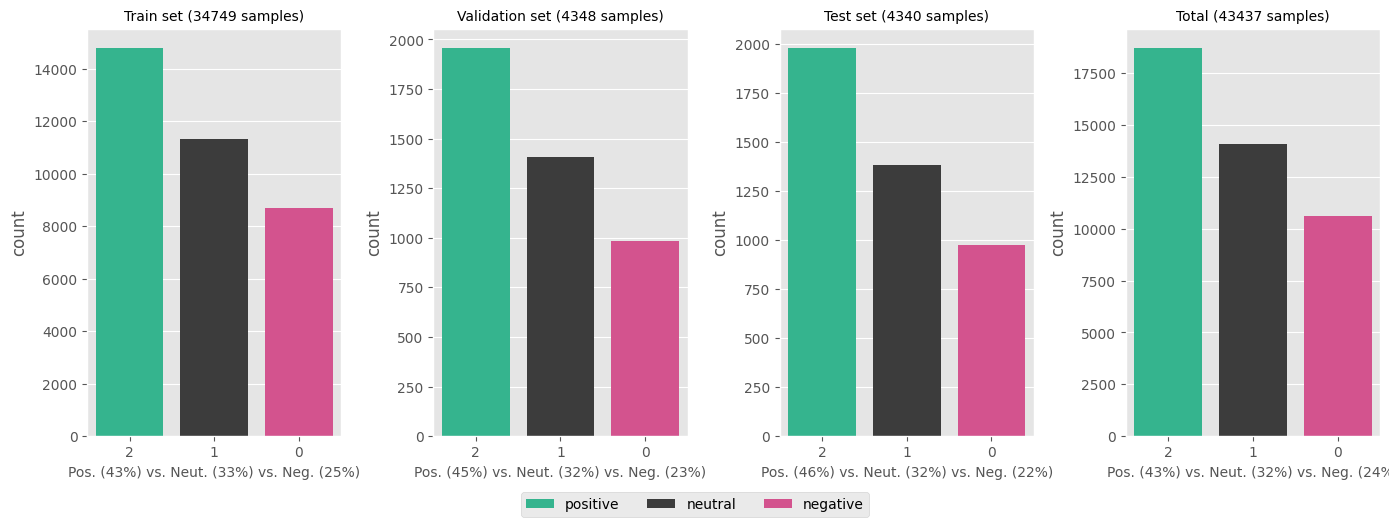

In [11]:
multiclass_train_ds = multiclass_ds[multiclass_ds.split == "train"]
multiclass_val_ds = multiclass_ds[multiclass_ds.split == "dev"]
multiclass_test_ds = multiclass_ds[multiclass_ds.split == "test"]

multiclass_train_total = multiclass_train_ds.shape[0]
multiclass_val_total = multiclass_val_ds.shape[0]
multiclass_test_total = multiclass_test_ds.shape[0]

train_positive_percent = round(multiclass_train_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)
dev_positive_percent = round(multiclass_val_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)
test_positive_percent = round(multiclass_test_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)
total_positive_percent = round(multiclass_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["positive"]] * 100)

train_neutral_percent = round(multiclass_train_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)
dev_neutral_percent = round(multiclass_val_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)
test_neutral_percent = round(multiclass_test_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)
total_neutral_percent = round(multiclass_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["neutral"]] * 100)

train_negative_percent = round(multiclass_train_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)
dev_negative_percent = round(multiclass_val_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)
test_negative_percent = round(multiclass_test_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)
total_negative_percent = round(multiclass_ds.label.value_counts(normalize=True)[MULTICLASS_LABEL_TO_ID_MAPPING["negative"]] * 100)


fig, ax = plt.subplots(1, 4, figsize=(14, 5))

sns.countplot(x="label", data=multiclass_train_ds, ax=ax[0], hue="label", palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[0].set_title(f"Train set ({multiclass_train_total} samples)", fontsize=10)
ax[0].set_xlabel(f"Pos. ({train_positive_percent}%) vs. Neut. ({train_neutral_percent}%) vs. Neg. ({train_negative_percent}%)", fontsize=10)
ax[0].get_legend().remove()

sns.countplot(x="label", data=multiclass_val_ds, ax=ax[1], hue="label", palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[1].set_title(f"Validation set ({multiclass_val_total} samples)", fontsize=10)
ax[1].set_xlabel(f"Pos. ({dev_positive_percent}%) vs. Neut. ({dev_neutral_percent}%) vs. Neg. ({dev_negative_percent}%)", fontsize=10)
ax[1].get_legend().remove()

sns.countplot(x="label", data=multiclass_test_ds, ax=ax[2], hue="label", palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[2].set_title(f"Test set ({multiclass_test_total} samples)", fontsize=10)
ax[2].set_xlabel(f"Pos. ({test_positive_percent}%) vs. Neut. ({test_neutral_percent}%) vs. Neg. ({test_negative_percent}%)", fontsize=10)
ax[2].get_legend().remove()

sns.countplot(x="label", data=multiclass_ds, ax=ax[3], hue="label", palette=MULTICLASS_PALETTE, order=[2, 1, 0])
ax[3].set_title(f"Total ({multiclass_train_total + multiclass_val_total + multiclass_test_total} samples)", fontsize=10)
ax[3].set_xlabel(f"Pos. ({total_positive_percent}%) vs. Neut. ({total_neutral_percent}%) vs. Neg. ({total_negative_percent}%)", fontsize=10)
ax[3].get_legend().remove()

handles, labels = ax[0].get_legend_handles_labels()
labels = [MULTICLASS_ID_TO_LABEL_MAPPING[int(label)] for label in labels]
fig.legend(handles[::-1], labels[::-1], loc='center', bbox_to_anchor=(0.5, -0.02), fancybox=True, ncol=3)

plt.tight_layout()
plt.show()

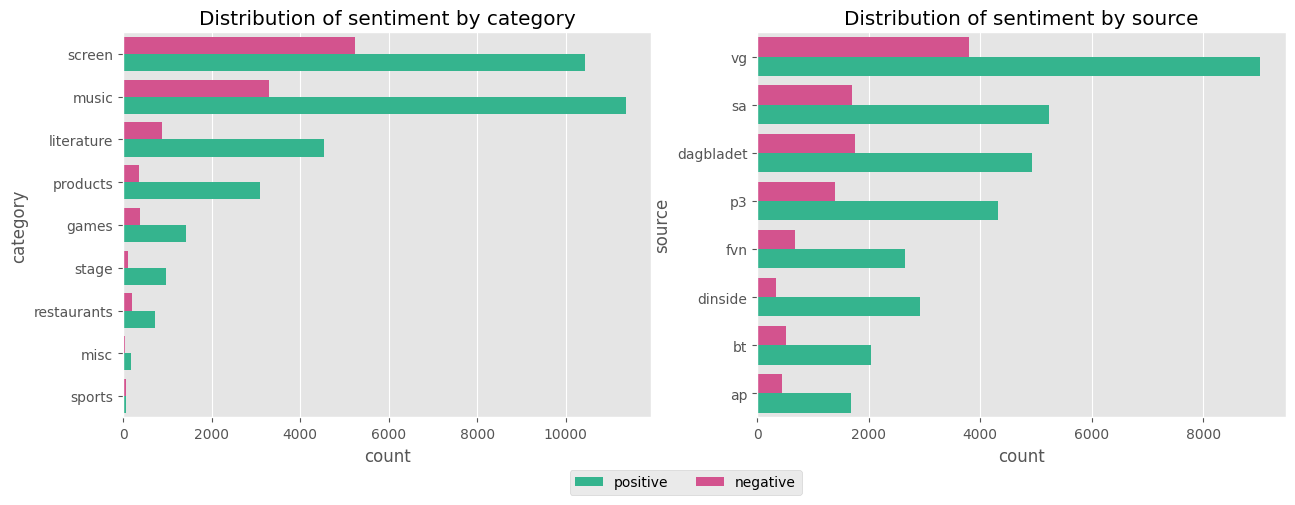

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(y="category", data=binary_ds, ax=ax[0], hue="label", palette=BINARY_PALETTE, order=binary_ds.category.value_counts().index)
ax[0].set_title("Distribution of sentiment by category")
ax[0].get_legend().remove()

sns.countplot(y="source", data=binary_ds, ax=ax[1], hue="label", palette=BINARY_PALETTE, order=binary_ds.source.value_counts().index)
ax[1].set_title("Distribution of sentiment by source")
ax[1].get_legend().remove()

handles, labels = ax[0].get_legend_handles_labels()
labels = [BINARY_ID_TO_LABEL_MAPPING[int(label)] for label in labels]
fig.legend(handles[::-1], labels[::-1], loc='center', bbox_to_anchor=(0.5, -0.02), fancybox=True, ncol=2)

plt.show()

# Review sentiment over time <a class="anchor" id="sentiment-time"></a>

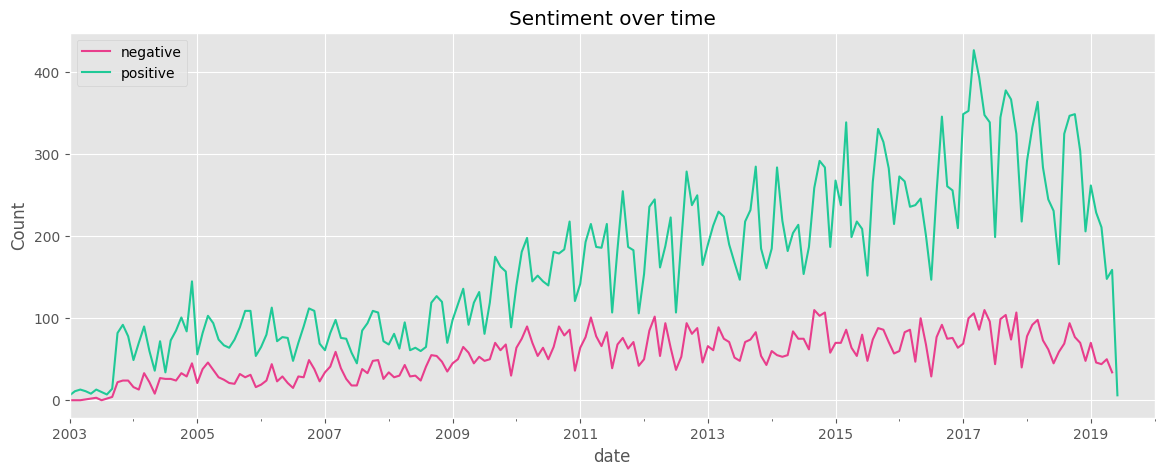

In [13]:
temp_df = binary_ds.copy()

temp_df['date'] = pd.to_datetime(temp_df['date'])
monthly_counts = temp_df.groupby('label').resample('ME', on='date').size()
monthly_counts = monthly_counts.reset_index(name='count')
monthly_counts['label'] = monthly_counts['label'].map(BINARY_ID_TO_LABEL_MAPPING)
pivot_df = monthly_counts.pivot(index='date', columns='label', values='count')

pivot_df.plot(kind='line', title='Sentiment over time', color=[NEGATIVE_COLOR, POSITIVE_COLOR], figsize=(14, 5))

plt.ylabel('Count')
plt.legend(loc='upper left')
plt.xlim([date(2003, 1, 1), date(2020, 1, 1)])
plt.show()

# n-gram analysis <a class="anchor" id="ngrams"></a>

In [14]:
def parse_ngrams(corpus: np.ndarray, n_gram: Tuple[int, int]) -> List[Tuple[str, int]]:
    vec = CountVectorizer(ngram_range=n_gram).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in tqdm(vec.vocabulary_.items(), desc=f"Processing {n_gram}-grams")]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

cleaned_binary_ds = NoReCDataPreprocessor().sanitize(binary_ds, "")
positive_review_corpus = cleaned_binary_ds[cleaned_binary_ds.label == 1].text.values
negative_review_corpus = cleaned_binary_ds[cleaned_binary_ds.label == 0].text.values

positive_words = parse_ngrams(positive_review_corpus, (1, 1))
positive_bigrams = parse_ngrams(positive_review_corpus, (2, 2))
positive_trigrams = parse_ngrams(positive_review_corpus, (3, 3))

negative_words = parse_ngrams(negative_review_corpus, (1, 1))
negative_bigrams = parse_ngrams(negative_review_corpus, (2, 2))
negative_trigrams = parse_ngrams(negative_review_corpus, (3, 3))


Processing  dataframe...


Processing (3, 3)-grams: 100%|██████████| 1863124/1863124 [00:02<00:00, 844620.98it/s]


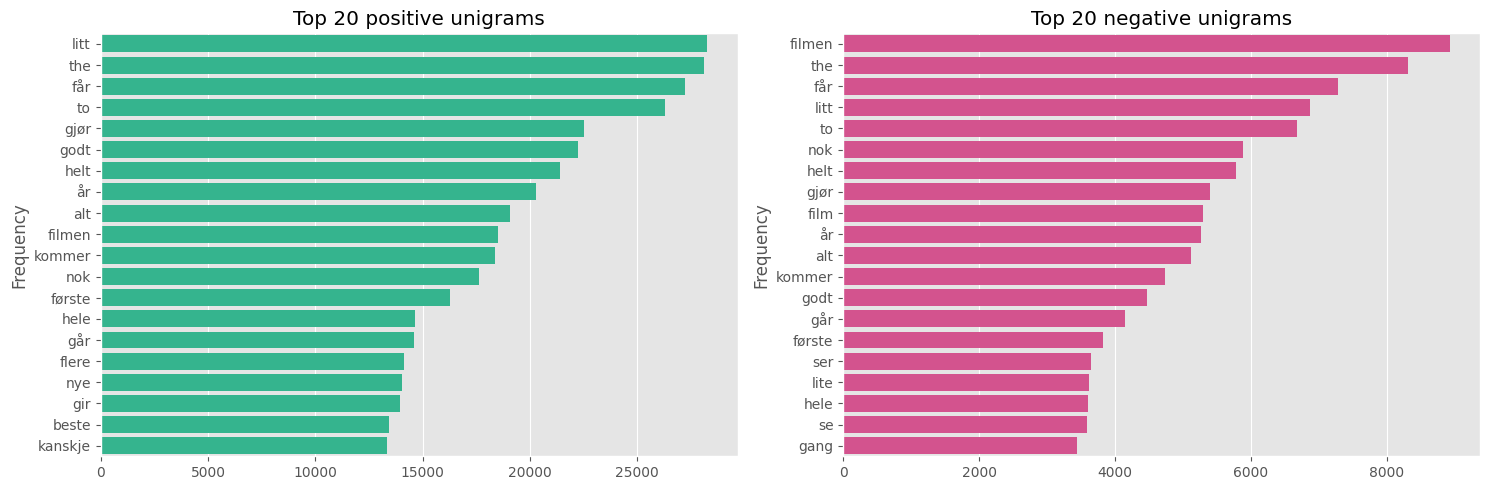

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in positive_words[:20]], x=[item[1] for item in positive_words[:20]], ax=ax[0], color=POSITIVE_COLOR)
ax[0].set_title("Top 20 positive unigrams")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in negative_words[:20]], x=[item[1] for item in negative_words[:20]], ax=ax[1], color=NEGATIVE_COLOR)
ax[1].set_title("Top 20 negative unigrams")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

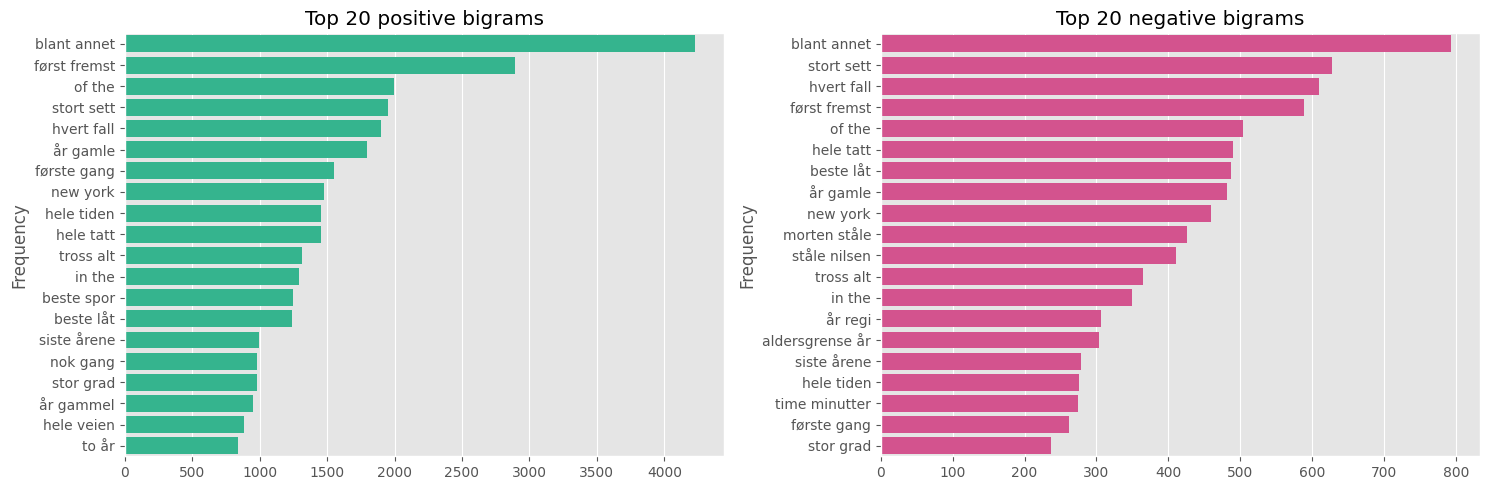

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in positive_bigrams[:20]], x=[item[1] for item in positive_bigrams[:20]], ax=ax[0], color=POSITIVE_COLOR)
ax[0].set_title("Top 20 positive bigrams")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in negative_bigrams[:20]], x=[item[1] for item in negative_bigrams[:20]], ax=ax[1], color=NEGATIVE_COLOR)
ax[1].set_title("Top 20 negative bigrams")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

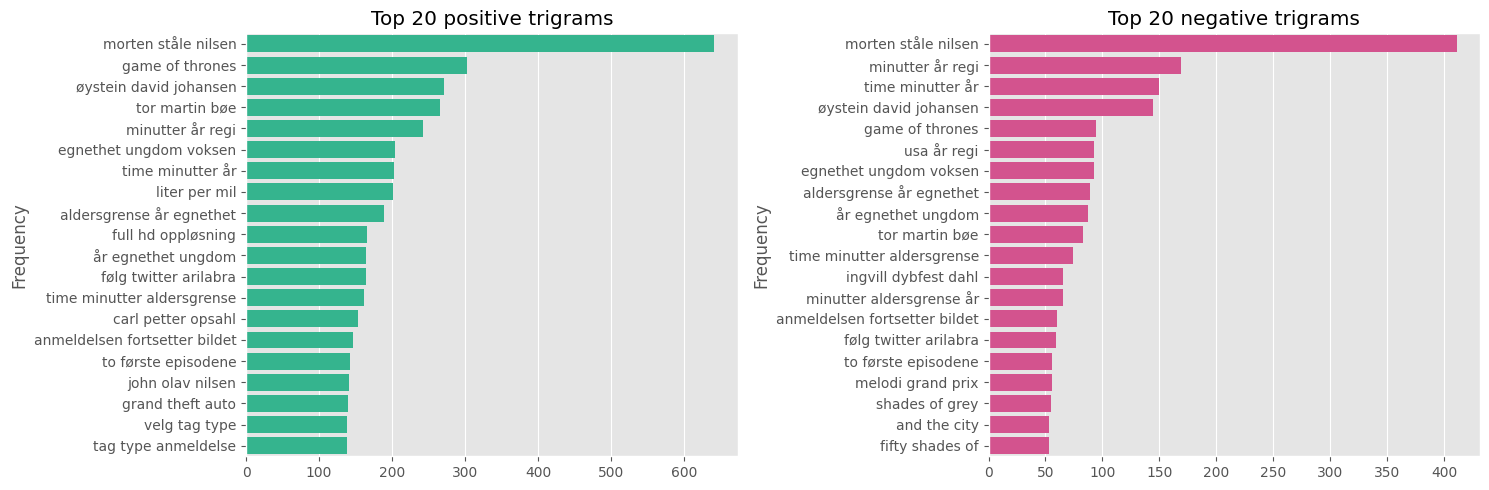

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in positive_trigrams[:20]], x=[item[1] for item in positive_trigrams[:20]], ax=ax[0], color=POSITIVE_COLOR)
ax[0].set_title("Top 20 positive trigrams")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in negative_trigrams[:20]], x=[item[1] for item in negative_trigrams[:20]], ax=ax[1], color=NEGATIVE_COLOR)
ax[1].set_title("Top 20 negative trigrams")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()